In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [37]:
#Load Datasets

## load Cleaned Data
cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")
cleaned_data.index = cleaned_data.index.astype(int)

#load geospatial data
tracts_geodata = gpd.read_file("tracts.geojson")
tracts_geodata = tracts_geodata.set_index("GEOID")
tracts_geodata.index = tracts_geodata.index.astype(int)

In [34]:
#Normalize Data

criteria = ['yearly_sunlight_kwh_total', 'owner_occupied', 'community_power_score', 'year_built', 
             'energy_burden', 'Percent of individuals < 100% Federal Poverty Line (percentile)',
             'PM2.5 in the air (percentile)', 'Current asthma among adults aged greater than or equal to 18 years (percentile)',
             'Housing burden (percent) (percentile)', 'Unemployment (percent) (percentile)']

normalized_data = cleaned_data.copy()

#minmax normalization
for criterion in criteria:
    normalized_data[criterion] = normalized_data[criterion] / (normalized_data[criterion].max() - normalized_data[criterion].min())

#z-score normalization (this assumes the datasets have normal distributions, but do they?)
# for criterion in weights.keys():
#     normalized_data[criterion] = (normalized_data[criterion] - normalized_data[criterion].mean()) / normalized_data[criterion].std()

In [35]:
#MCDA for Feasibility, Impact, Co-Benefits

weights_feasibility = {
    'yearly_sunlight_kwh_total': 0.4,
    'owner_occupied': 0.3,
    'community_power_score': 0.2,
    'year_built': 0.1
}

weights_impact = {
    'yearly_sunlight_kwh_total': 0.4,
    'energy_burden': 0.35,
    'Percent of individuals < 100% Federal Poverty Line (percentile)': 0.25
}

weights_cobenefits = {
    'PM2.5 in the air (percentile)': 0.3,
    'Unemployment (percent) (percentile)': 0.3,
    'Current asthma among adults aged greater than or equal to 18 years (percentile)': 0.2,
    'Housing burden (percent) (percentile)': 0.2
}

mcda_output = pd.DataFrame()

# Perform the weighted sum calculation
mcda_output['feasibility_score'] = (normalized_data[list(weights_feasibility.keys())] * list(weights_feasibility.values())).sum(axis=1)
mcda_output['impact_score'] = (normalized_data[list(weights_impact.keys())] * list(weights_impact.values())).sum(axis=1)
mcda_output['cobenefits_score'] = (normalized_data[list(weights_cobenefits.keys())] * list(weights_cobenefits.values())).sum(axis=1)

# Categorize the scores
# bins = [0, 0.33, 0.67, 1]
labels = ['low', 'med', 'high']
mcda_output['feasibility_potential'] = pd.cut(mcda_output['feasibility_score'], bins=3, labels=labels, include_lowest=True)
mcda_output['impact_potential'] = pd.cut(mcda_output['impact_score'], bins=3, labels=labels, include_lowest=True)
mcda_output['cobenefits_potential'] = pd.cut(mcda_output['cobenefits_score'], bins=3, labels=labels, include_lowest=True)

##Q: How does the binning work? Important to understand the results
print(mcda_output.head)

<bound method NDFrame.head of              feasibility_score  impact_score  cobenefits_score   
GEOID                                                            
1001020200            0.337906      0.210378          0.616525  \
1001020300            0.350945      0.261956          0.525960   
1001020700            0.343272      0.311483          0.783172   
1003010400            0.401086      0.187093          0.306202   
1003010903            0.366183      0.186398          0.430444   
...                        ...           ...               ...   
56025000800           0.368707      0.161782          0.403111   
56025000901           0.369673      0.199984          0.346768   
56025001100           0.396697      0.125212          0.371798   
56025001200           0.403680      0.208544          0.444586   
56025001401           0.420815      0.161210          0.392182   

            feasibility_potential impact_potential cobenefits_potential  
GEOID                                

In [36]:
#print
print(mcda_output['feasibility_potential'].value_counts())
print(mcda_output['impact_potential'].value_counts())
print(mcda_output['cobenefits_potential'].value_counts())

feasibility_potential
med     20673
high     4890
low      2343
Name: count, dtype: int64
impact_potential
low     13925
med     13901
high       80
Name: count, dtype: int64
cobenefits_potential
med     15377
high    10293
low      2236
Name: count, dtype: int64


Text(0.5, 1.0, 'Co-Benefits Potential by Census Tract')

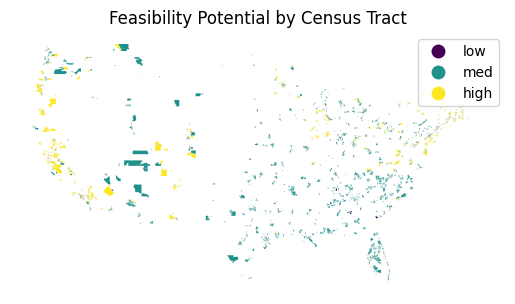

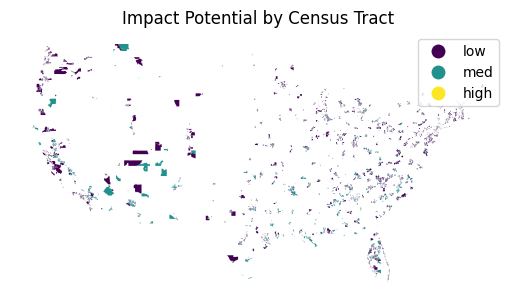

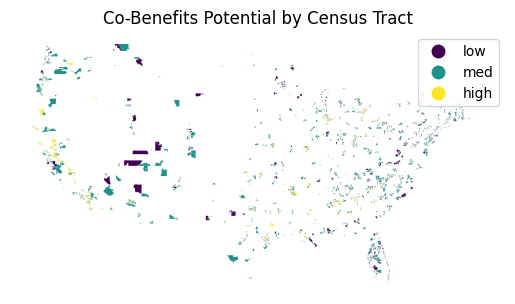

In [39]:
#Merge geometry attributes with normalized data
mcda_geodata = tracts_geodata.merge(mcda_output, left_index=True, right_index=True)

#Map potential
feasibility_map = mcda_geodata.plot("feasibility_potential", legend=True, cmap='viridis')
impact_map = mcda_geodata.plot("impact_potential", legend=True, cmap='viridis')
cobenefits_map = mcda_geodata.plot("cobenefits_potential", legend=True, cmap='viridis')

feasibility_map.set_axis_off()
feasibility_map.set_title("Feasibility Potential by Census Tract")

impact_map.set_axis_off()
impact_map.set_title("Impact Potential by Census Tract")

cobenefits_map.set_axis_off()
cobenefits_map.set_title("Co-Benefits Potential by Census Tract")


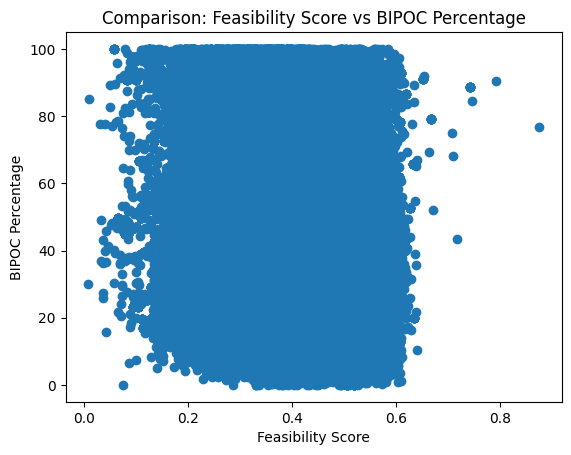

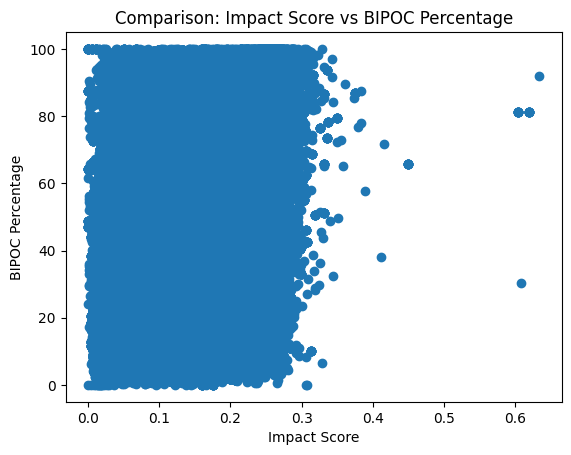

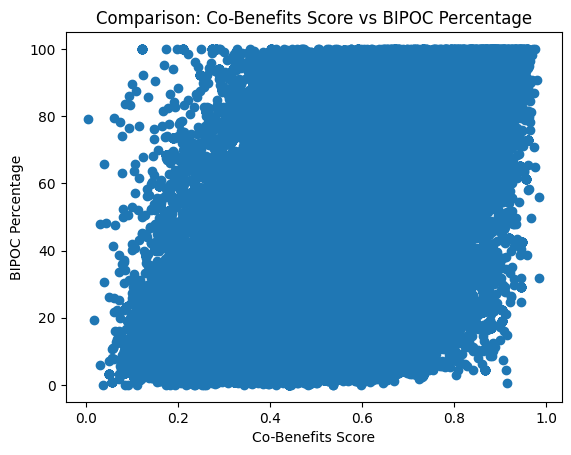

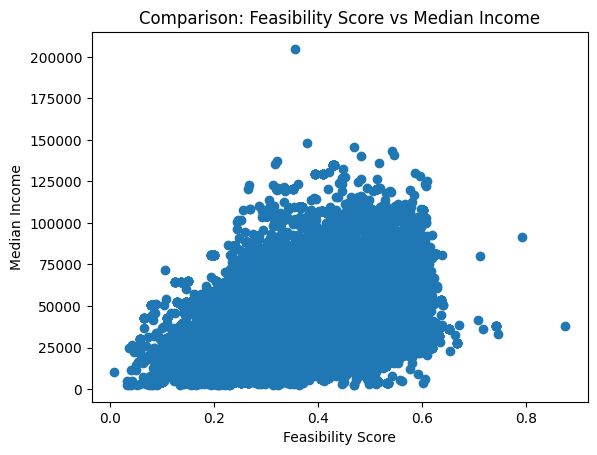

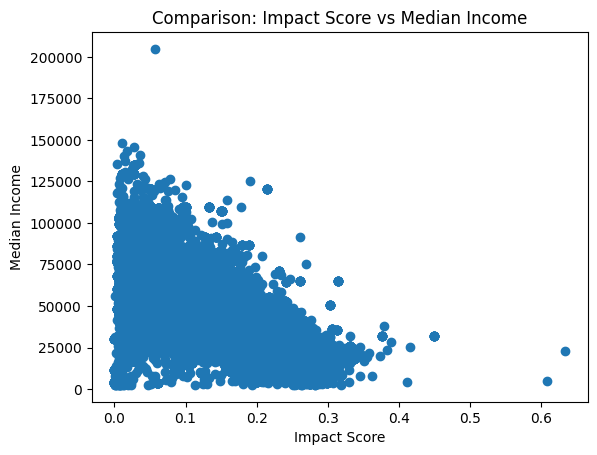

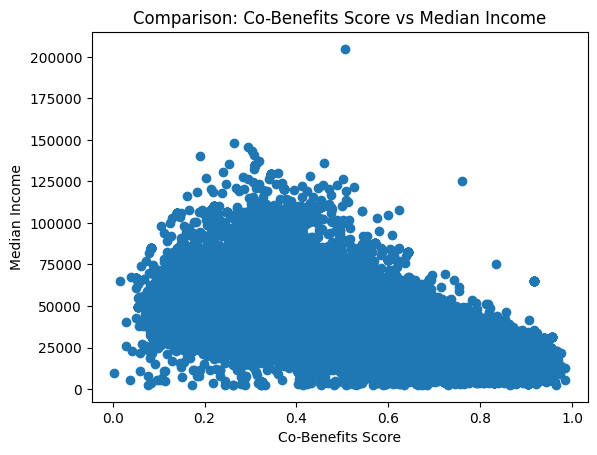

In [30]:
#Compare potential with Income, BIPOC, # of existing installs

# # Merge the mcda output data back into original dataframe
# mcda_data = merged_data.merge(mcda_output, left_index=True, right_index=True)



# Scatter plot of 'feasibility_score' vs 'bipoc_percent'
plt.scatter(merged_data['feasibility_score'], merged_data['bipoc_percent'])
plt.xlabel('Feasibility Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Feasibility Score vs BIPOC Percentage')
plt.show()

plt.scatter(merged_data['impact_score'], merged_data['bipoc_percent'])
plt.xlabel('Impact Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Impact Score vs BIPOC Percentage')
plt.show()

plt.scatter(merged_data['cobenefits_score'], merged_data['bipoc_percent'])
plt.xlabel('Co-Benefits Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Co-Benefits Score vs BIPOC Percentage')
plt.show()

# Scatter plot of 'feasibility_score' vs 'median_income'
plt.scatter(merged_data['feasibility_score'], merged_data['median_income'])
plt.xlabel('Feasibility Score')
plt.ylabel('Median Income')
plt.title('Comparison: Feasibility Score vs Median Income')
plt.show()

plt.scatter(merged_data['impact_score'], merged_data['median_income'])
plt.xlabel('Impact Score')
plt.ylabel('Median Income')
plt.title('Comparison: Impact Score vs Median Income')
plt.show()

plt.scatter(merged_data['cobenefits_score'], merged_data['median_income'])
plt.xlabel('Co-Benefits Score')
plt.ylabel('Median Income')
plt.title('Comparison: Co-Benefits Score vs Median Income')
plt.show()

